## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# reading the Treebank tagged sentences
universal_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# Splitting into train and test
train_set, test_set = train_test_split(universal_data, test_size=0.05, random_state=234)

print(len(train_set))
print(len(test_set))

3718
196


In [5]:
# Getting the list of test and train tagged words
tagged_words_train = [tup for sent in train_set for tup in sent]
print("Train Tagged Words - ", len(tagged_words_train))

tagged_words_test = [tup for sent in test_set for tup in sent]
print("Train Tagged Words - ", len(tagged_words_test))

Train Tagged Words -  95253
Train Tagged Words -  5423


In [6]:
# Getting an idea of train tag set
tagged_words_train[:20]

[('Companies', 'NOUN'),
 ('listed', 'VERB'),
 ('*', 'X'),
 ('below', 'ADP'),
 ('reported', 'VERB'),
 ('quarterly', 'ADJ'),
 ('profit', 'NOUN'),
 ('substantially', 'ADV'),
 ('different', 'ADJ'),
 ('from', 'ADP'),
 ('the', 'DET'),
 ('average', 'NOUN'),
 ('of', 'ADP'),
 ('analysts', 'NOUN'),
 ("'", 'PRT'),
 ('estimates', 'NOUN'),
 ('.', '.'),
 ('The', 'DET'),
 ('prevailing', 'VERB'),
 ('interpretation', 'NOUN')]

In [7]:
# Tokens 
tokens_train = set([pair[0] for pair in tagged_words_train])
print ('Length of Tokens in train set is',len(tokens_train))
# Number of tags
tags_train = set([pair[1] for pair in tagged_words_train])
print ('Length of POS tags in train set is',len(tags_train))

Length of Tokens in train set is 12010
Length of POS tags in train set is 12


Emmision Probability

In [8]:
# Function to compute the Emission Probability of a given word
def emmisionProbability(word, tag, train_bag = tagged_words_train):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(tag_list)
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    word_given_tag_count = len(word_given_tag_list)

    return (word_given_tag_count, tag_count)

Transition probabilities

In [9]:
# Funtion to Compute Transition Probability i.e. tag2(t2) given tag1(t1)   

def transitionProbability(t2, t1, train_bag = tagged_words_train):
    tags = [pair[1] for pair in train_bag]

    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    
    return (count_t2_t1, count_t1)

In [10]:
# Creating t x t transition matrix of training POS tags

transition_matrix = np.zeros((len(tags_train), len(tags_train)), dtype='float32') 

for i, t1 in enumerate(list(tags_train)):
    for j, t2 in enumerate(list(tags_train)): 
        transition_matrix[i, j] = transitionProbability(t2, t1)[0]/transitionProbability(t2, t1)[1]

In [11]:
# Creating a dataframe for better readability
tags_df = pd.DataFrame(transition_matrix, columns = list(tags_train), index=list(tags_train))

In [12]:
tags_df

,PRT,ADJ,X,VERB,DET,ADP,.,ADV,PRON,NOUN,NUM,CONJ
PRT,0.001978,0.084707,0.013514,0.404087,0.101516,0.021094,0.040870,0.010547,0.018128,0.245550,0.056032,0.001978
ADJ,0.010760,0.064559,0.020857,0.011753,0.004801,0.078464,0.064393,0.004469,0.000497,0.701374,0.021354,0.016719
X,0.184206,0.016876,0.076262,0.204904,0.054609,0.144722,0.163668,0.025633,0.056997,0.059545,0.002707,0.009871
VERB,0.030998,0.065329,0.218304,0.169870,0.133524,0.091367,0.035105,0.082378,0.035183,0.109888,0.022629,0.005425
DET,0.000242,0.205897,0.045916,0.039995,0.005437,0.009425,0.017641,0.013050,0.003504,0.636056,0.022354,0.000483
ADP,0.001175,0.105117,0.034078,0.008226,0.323683,0.016985,0.039633,0.013781,0.069223,0.325179,0.062280,0.000641
.,0.002447,0.044869,0.027375,0.089104,0.174492,0.091914,0.093002,0.053028,0.066624,0.219634,0.079405,0.058013
ADV,0.013536,0.131066,0.023110,0.344338,0.069330,0.119511,0.133707,0.080224,0.015847,0.030373,0.031694,0.007263
PRON,0.012256,0.072386,0.094217,0.487936,0.009958,0.022214,0.039831,0.033321,0.007277,0.208732,0.007277,0.004596
NOUN,0.043775,0.011972,0.029269,0.147778,0.013515,0.177488,0.239221,0.017150,0.004811,0.263313,0.009512,0.042196


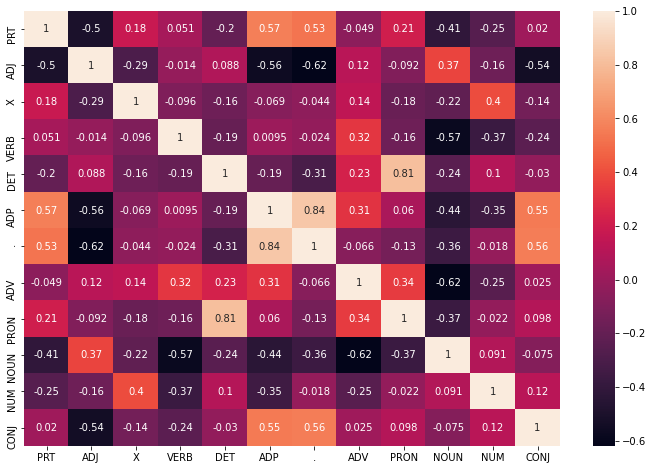

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(tags_df.corr(),annot=True)
plt.show()

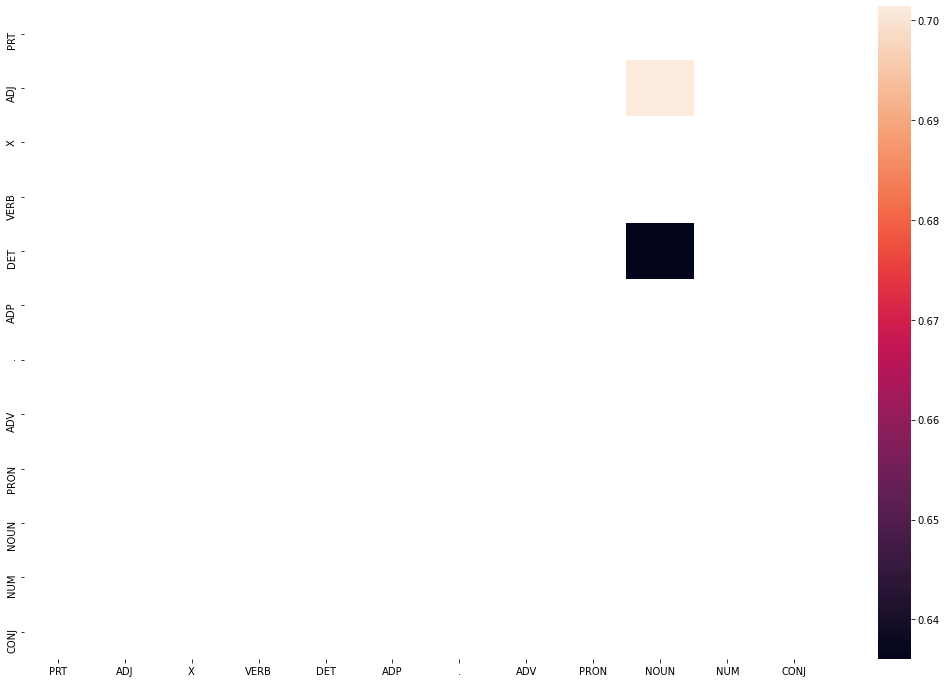

In [14]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [15]:
# Viterbi Heuristic
def vanillaViterbi(words, train_bag = tagged_words_train):
    state = []

    tags_list = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        probability_list = [] 
        for tag in tags_list:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emmisionProbability(words[key], tag)[0]/emmisionProbability(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            probability_list.append(state_probability)
            
        max_probability = max(probability_list)

        # getting state for which probability is maximum
        state_max = tags_list[probability_list.index(max_probability)] 
        state.append(state_max)

    return list(zip(words, state))


In [16]:
# Testing the vanilla Viterbi on sample test set
# To reduce the computation time, only 20 random sentences from the test_set are taken
random.seed(234)

numbers = [random.randint(1, len(test_set)) for x in range(20)]

sentences = [test_set[i] for i in numbers]

# Storing the list of tagged words
word_tag_validation = [tup for sent in sentences for tup in sent]

# Storing the untagged words
untagged_words = [tup[0] for sent in sentences for tup in sent]

In [17]:
# Tagging the test sentences using vanilla viterbi
start = time.time()
tagged_seq = vanillaViterbi(untagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)


Time taken in seconds:  92.51577425003052


In [18]:
print(untagged_words)
print(tagged_seq)

['They', 'succeed', 'Daniel', 'M.', 'Rexinger', ',', 'retired', 'Circuit', 'City', 'executive', 'vice', 'president', ',', 'and', 'Robert', 'R.', 'Glauber', ',', 'U.S.', 'Treasury', 'undersecretary', ',', 'on', 'the', '12-member', 'board', '.', 'Miami', 'Dolphins', 'owner', 'Joe', 'Robbie', 'disagrees', ',', 'and', 'he', 'can', 'prove', 'it', '.', 'American', 'Express', 'also', 'represents', 'the', 'upscale', 'image', '0', '``', 'we', "'re", 'trying', '*-2', 'to', 'project', '*T*-1', ',', "''", 'she', 'adds', '*T*-3', '.', 'A', 'majority', 'of', 'an', 'NIH-appointed', 'panel', 'recommended', 'late', 'last', 'year', 'that', 'the', 'research', 'continue', 'under', 'carefully', 'controlled', 'conditions', ',', 'but', 'the', 'issue', 'became', 'embroiled', '*-2', 'in', 'politics', 'as', 'anti-abortion', 'groups', 'continued', '*-3', 'to', 'oppose', 'federal', 'funding', '.', 'Both', 'contracts', 'have', 'gained', 'a', 'following', 'since', 'the', '1987', 'global', 'market', 'crash', '.', 'I

In [19]:
# Evalutating the accuracy of Vanilla Viterbi
check = [i for i, j in zip(tagged_seq, word_tag_validation) if i == j]
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.8975791433891993


In [20]:
# Looking at the incorrectly tagged words
incorrectly_tagged_words = [i for i, j in zip(tagged_seq, untagged_words) if i != j]
print(incorrectly_tagged_words)

[('They', 'PRON'), ('succeed', 'VERB'), ('Daniel', 'NOUN'), ('M.', 'NOUN'), ('Rexinger', 'PRT'), (',', '.'), ('retired', 'VERB'), ('Circuit', 'PRT'), ('City', 'NOUN'), ('executive', 'NOUN'), ('vice', 'NOUN'), ('president', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('Robert', 'NOUN'), ('R.', 'NOUN'), ('Glauber', 'PRT'), (',', '.'), ('U.S.', 'NOUN'), ('Treasury', 'NOUN'), ('undersecretary', 'NOUN'), (',', '.'), ('on', 'ADP'), ('the', 'DET'), ('12-member', 'PRT'), ('board', 'NOUN'), ('.', '.'), ('Miami', 'NOUN'), ('Dolphins', 'PRT'), ('owner', 'NOUN'), ('Joe', 'NOUN'), ('Robbie', 'NOUN'), ('disagrees', 'PRT'), (',', '.'), ('and', 'CONJ'), ('he', 'PRON'), ('can', 'VERB'), ('prove', 'VERB'), ('it', 'PRON'), ('.', '.'), ('American', 'NOUN'), ('Express', 'NOUN'), ('also', 'ADV'), ('represents', 'VERB'), ('the', 'DET'), ('upscale', 'ADJ'), ('image', 'NOUN'), ('0', 'X'), ('``', '.'), ('we', 'PRON'), ("'re", 'VERB'), ('trying', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('project', 'NOUN'), ('*T*-1', 'X'

In [21]:
# Looking at the unknown words present in the entire train and test set

vocab_test_set = set([tup[0] for tup in tagged_words_test])
vocab_train_set = set([tup[0] for tup in tagged_words_train])

all_unknown_words = list(vocab_test_set - vocab_train_set)
print(all_unknown_words)

['Velcro', '150,000', 'three-digit', 'discouraging', 'compatible', '*-98', 'struggled', '1.39', 'Donuts', 'sparkplugs', 'Prize', 'skittishness', 'marketers', 'worthy', 'Rae', 'High-grade', 'X', '618.1', 'educated', 'literary', 'blender', 'Social', 'shoring', 'spurring', 'Cellars', 'Ricken', 'Deane', '8.70', 'authorized', 'property\\/casualty', 'vast', 'Denver', 'newcomer', 'disappear', '188.84', '274', 'single-lot', 'Orville', 'capability', 'invention', 'folio', '35.2', 'Woodcliff', 'la', 'Hale', 'Legislation', 'Joanne', 'alerts', 'Mrs', 'fabricate', 'sight', 'NATIONAL', 'Precious', 'passport', 'Us', 'waivers', 'Phoenix', 'Meinders', 'diverse', 'Kingsbridge', 'Pick', 'hysteria', 'influenced', 'insanity', '150-point', 'downright', 'Wertheim', 'microcomputers', 'Rust', 'thumbs', 'Wamre', 'obtaining', 'relation', 'citation', 'Equivalents', 'Editorials', 'Rita', 'Congressman', '446.62', 'extramarital', 'anywhere', 'academics', '*T*-178', 'buckle', 'Invariably', 'creator', '420', 'Composite

In [22]:
vocab_test_set = set([tup for tup in untagged_words])
vocab_train_set = set([tup[0] for tup in tagged_words_train])

unknown_words = list(vocab_test_set - vocab_train_set)
print(unknown_words)
print("Unknown words count =",len(unknown_words))

['NIH-appointed', '8.70', 'Rexinger', 'disagrees', '420', '6\\/2', 'Pick', '*T*-203', 'Montgomery', '92.9', '1.18', 'carefully', 'spooked', 'propagandize', 'precise', 'Inns', '77.6', 'heavy-truck', 'embroiled', 'beforehand', 'trail', 'recommended', 'anti-abortion', '9.75', 'Glauber', '93.9', 'telegraph', '1.19', 'Dolphins', 'Circuit', 'zero', 'nonfat', '12-member', '618.1', 'ASSOCIATION', '88.32', 'NATIONAL', 'passenger-car']
Unknown words count = 38


### Solve the problem of unknown words

In [23]:
# Modified Viterbi Heuristic for unknown words
def Viterbi_I(words, train_bag = tagged_words_train):
    state = []

    tags_list = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):

        #initialise list of probability column for a given observation
        probability_list = [] 

        # Empty list to store transition probability
        transition_probability_list = []

        for tag in tags_list:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emmisionProbability(words[key], tag)[0]/emmisionProbability(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            probability_list.append(state_probability)
            transition_probability_list.append(transition_p)
            
        max_probability = max(probability_list)

        if max_probability == 0:
          max_probability = max(transition_probability_list)
          state_max = tags_list[transition_probability_list.index(max_probability)]
        else:
          # getting state for which probability is maximum
          state_max = tags_list[probability_list.index(max_probability)] 
          
        state.append(state_max)

    return list(zip(words, state))

In [24]:
def bigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'.*ly$', 'ADV'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    bigram_regex_tagger = nltk.BigramTagger(train_set, backoff = regex_based_tagger)
    return bigram_regex_tagger.tag_sents([[(word)]])

In [25]:
def Viterbi_II(words, train_bag = tagged_words_train):
    state = []

    tags_list = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
      if word not in vocab_train_set:
        unknown_word_tag = bigram_tagger(word)
        for sentence in unknown_word_tag:
           for tup in sentence:
             state.append(tup[1])
      else:
        probability_list = [] 
        for tag in tags_list:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emmisionProbability(words[key], tag)[0]/emmisionProbability(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            probability_list.append(state_probability)
            
        max_probability = max(probability_list)

        # getting state for which probability is maximum
        state_max = tags_list[probability_list.index(max_probability)] 
        state.append(state_max)

    return list(zip(words, state))

#### Evaluating tagging accuracy

In [26]:
# Function to evaluate the accuracy
def accuracy_check(tagged_sequence, word_tag_validation):
    check = [i for i, j in zip(tagged_sequence, word_tag_validation) if i == j] 
    accuracy = len(check)/len(tagged_sequence)
    return format(round(accuracy*100,2))


In [27]:
start = time.time()
viterbi_seq = vanillaViterbi(untagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
viterbi_accuracy = accuracy_check(viterbi_seq, word_tag_validation)
print('Vanilla Viterbi Accuracy {0}'.format(viterbi_accuracy))

Time taken in seconds:  93.28129386901855
Vanilla Viterbi Accuracy 89.76


In [28]:
start = time.time()
viterbiI_seq = Viterbi_I(untagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
viterbi_I_accuracy = accuracy_check(viterbiI_seq, word_tag_validation)
print('Viterbi Modification 1 Accuracy {0}'.format(viterbi_I_accuracy))

Time taken in seconds:  92.3424859046936
Viterbi Modification 1 Accuracy 91.99


In [29]:
start = time.time()
viterbiII_seq = Viterbi_II(untagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
viterbi_II_accuracy = accuracy_check(viterbiII_seq, word_tag_validation)
print('Viterbi Modification 2 Accuracy {0}'.format(viterbi_II_accuracy))

Time taken in seconds:  166.38787031173706
Viterbi Modification 2 Accuracy 95.34


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [30]:
accuracy_list = [float(viterbi_accuracy),
                 float(viterbi_I_accuracy),
                 float(viterbi_II_accuracy)]

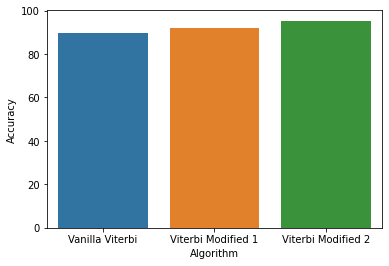

In [31]:
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
sns.barplot(x=['Vanilla Viterbi','Viterbi Modified 1', 'Viterbi Modified 2'], y=accuracy_list)
plt.show()

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [32]:
def listTags(vanilla_tags, modified_tags, word_tag_validation) :
  correctly_tagged_list = []
  for i,j,k in zip(vanilla_tags, modified_tags, word_tag_validation):
        if (i != k) & (j == k):
          correctly_tagged_list.append([i,j,k])
  return  correctly_tagged_list

In [33]:
corrected_viterbi_I = listTags(viterbi_seq, viterbiI_seq,word_tag_validation  )

In [34]:
pd.DataFrame(corrected_viterbi_I, columns= ['Venilla Viterbi', 'Viterbi Modification I', 'Actual Tag'])

,Venilla Viterbi,Viterbi Modification I,Actual Tag
0,"(Rexinger, PRT)","(Rexinger, NOUN)","(Rexinger, NOUN)"
1,"(Glauber, PRT)","(Glauber, NOUN)","(Glauber, NOUN)"
2,"(Dolphins, PRT)","(Dolphins, NOUN)","(Dolphins, NOUN)"
3,"(heavy-truck, PRT)","(heavy-truck, NOUN)","(heavy-truck, NOUN)"
4,"(passenger-car, PRT)","(passenger-car, NOUN)","(passenger-car, NOUN)"
5,"(Pick, PRT)","(Pick, VERB)","(Pick, VERB)"
6,"(NATIONAL, PRT)","(NATIONAL, NOUN)","(NATIONAL, NOUN)"
7,"(ASSOCIATION, PRT)","(ASSOCIATION, NOUN)","(ASSOCIATION, NOUN)"
8,"(Inns, PRT)","(Inns, NOUN)","(Inns, NOUN)"
9,"(Montgomery, PRT)","(Montgomery, NOUN)","(Montgomery, NOUN)"


In [35]:
corrected_viterbi_II = listTags(viterbi_seq, viterbiII_seq, word_tag_validation  )

In [36]:
pd.DataFrame(corrected_viterbi_II, columns= ['Venilla Viterbi', 'Viterbi Modification II', 'Actual Tag'])

,Venilla Viterbi,Viterbi Modification II,Actual Tag
0,"(Rexinger, PRT)","(Rexinger, NOUN)","(Rexinger, NOUN)"
1,"(Circuit, PRT)","(Circuit, NOUN)","(Circuit, NOUN)"
2,"(Glauber, PRT)","(Glauber, NOUN)","(Glauber, NOUN)"
3,"(12-member, PRT)","(12-member, ADJ)","(12-member, ADJ)"
4,"(Dolphins, PRT)","(Dolphins, NOUN)","(Dolphins, NOUN)"
5,"(disagrees, PRT)","(disagrees, VERB)","(disagrees, VERB)"
6,"(NIH-appointed, PRT)","(NIH-appointed, ADJ)","(NIH-appointed, ADJ)"
7,"(recommended, PRT)","(recommended, VERB)","(recommended, VERB)"
8,"(carefully, PRT)","(carefully, ADV)","(carefully, ADV)"
9,"(embroiled, PRT)","(embroiled, VERB)","(embroiled, VERB)"
